# 01 - Introduction to seismic modelling

This notebook is the first in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this first example we aim to highlight the core ideas behind seismic modelling, where we create a numerical model that captures the processes involved in a seismic survey. This forward model will then form the basis for further tutorials on the implementation of inversion processes using Devito operators.

## Modelling workflow

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single or a few physical location where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous  sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recoded at multiple locations, and usually at the surface of the domain or at the bottom of the ocean in some marine cases.

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the  source and record the seismic wave at sparse point locations in the grid.


<img src='./survey-ship-diagram.png' width=400>

## The acoustic seismic wave equation
The acoustic wave equation for the square slowness $m$ defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases}
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) = q \ \text{in } \Omega \\
 &u(.,t=0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.
The boundary conditions are Dirichlet conditions :
\begin{equation}
 u(x,t)|_\delta\Omega = 0
\end{equation}

where $\delta\Omega$ is the surface of the boundary of the model $\Omega$.


# Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every directions to an "infinite" distance. However, solving the wave equation in a mathematically/discrete infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfectly Matched Layers (PML) are required to mimic an infinite domain. These two method allow to approximate an infinite media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. The core idea is to extend the physical domain and to add a Sponge mask in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) + \eta \frac{d u(x,t)}{dt}=q  \ \text{in } \Omega \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from linear to exponential.

# Seismic modelling with devito

We describe here a step by step setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source and an according set of receivers to model for the forward model. But first, we initialize some basic utilities.

In [1]:
import numpy as np
%matplotlib inline

## Define the physical problem

The first step is to define the physical model:

- What are the physical dimension of interest
- What is the velocity profile of this physical domain

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of two layers, each with a different velocity: $1.5km/s$ in the top layer and $2.5km/s$ in the bottom layer. We will use this simple model a lot in the following tutorials, so we will rely on a utility function to create it again later.

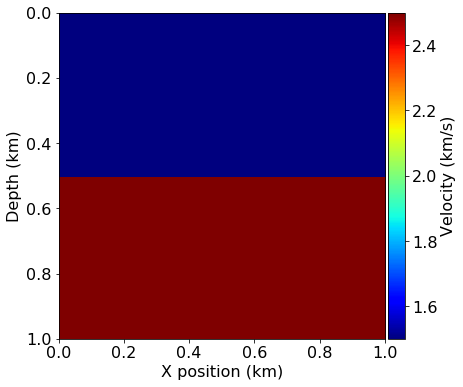

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbpml=10)

plot_velocity(model)

# Acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to model and the set of receiver locations at which to sample the wavefield. The source time signature will be modelled using a Ricker wavelet defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}
\end{equation}

To fully define the source signature we first need to define the time duration for our model and the timestep size, which is dictated by the CFL condition and our grid spacing. Luckily, our `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array:

In [3]:
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

The source is positioned at a $20m$ depth and at the middle of the $x$ axis ($x_{src}=500m$), with a peak wavelet frequency of $10Hz$.

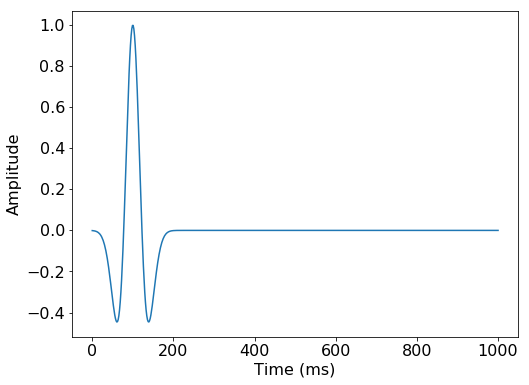

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`. It is worth noting here that both utility classes, `RickerSource` and `Receiver` are thin wrappers around Devito's `PointData` type, which encapsulates sparse point data and allows us to inject and interpolate values into and out of the computational grid. As we have already seen, both types provide a `point.coordinates` property to define the position within the domain of all points encapsulated by that symbol. 

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

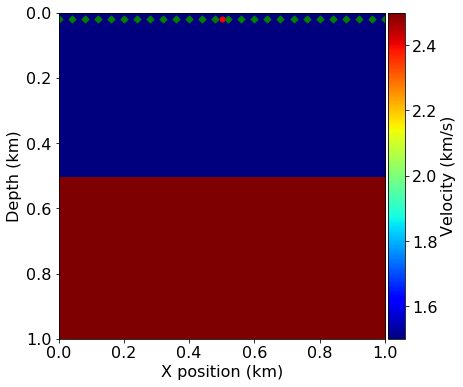

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, ntime=nt)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

# Finite-difference discretization

Devito is a finite-difference DSL that solves the discretized wave-equation on a Cartesian grid. The finite-difference approximation is derived from Taylor expansions of the continuous field after removing the error term.

## Time discretization

We only consider the second order time discretization for now. From the Taylor expansion, the second order discrete approximation of the second order time derivative is:
\begin{equation}
\begin{aligned}
 \frac{d^2 u(x,t)}{dt^2} = \frac{\mathbf{u}(\mathbf{x},\mathbf{t+\Delta t}) - 2 \mathbf{u}(\mathbf{x},\mathbf{t}) + \mathbf{u}(\mathbf{x},\mathbf{t-\Delta t})}{\mathbf{\Delta t}^2} + O(\mathbf{\Delta t}^2).
\end{aligned}
\end{equation} 

where $\mathbf{u}$ is the discrete wavefield, $\mathbf{\Delta t}$ is the discrete
time-step (distance between two consecutive discrete times) and $O(\mathbf{\Delta
  t}^2)$ is the discretization error term. The discretized approximation of the
second order time derivative is then given by dropping the error term. This derivative is represented in Devito by `u.dt2` where u is a `TimeFunction` object.

## Spatial discretization 

We define the discrete Laplacian as the sum of the second order spatial
derivatives in the three dimensions:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}

This derivative is represented in Devito by `u.laplace` where u is a `TimeFunction` object.

## Wave equation

With the space and time discretization defined, we can fully discretize the wave-equation with the combination of time and space discretizations and obtain the following second order in time and $k^{th}$ order in space discrete stencil to update one grid point at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.
\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

In [6]:
# In order to represent the wavefield u and the square slowness we need symbolic object 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using sympy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward)[0])

# Source injection and receiver interpolation

With a numerical scheme to solve the homogenous wave equation, we need to add the source to introduce seismic waves and to implement the measurement operator, and interpolation operator. This operation are linked to the discrete scheme and need to be done at the proper time step. The semi-discretized in time wave equation with a source reads:

\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

It shows that in order to update $\mathbf{u}$ at time $\mathbf{t+\Delta t}$ we have to inject the value of the source term $\mathbf{q}$ of time $\mathbf{t}$. In Devito, it correspond the update of $u$ at index $t+1$ (t = time implicitly) with the source of time $t$.
On the receiver side, the problem is either as it only require to record the data at the given time step $t$ for the in the receiver at time $time=t$.


In [7]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u, offset=model.nbpml)

# Devito operator and solve
After constructing all the necessary expressions for updating the wavefield, injecting the source term and interpolating onto the receiver points, we can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:
* **DSE:** The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
* **DLE:** The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

**Note**: The argument `subs=model.spacing_map` causes the operator to substitute values for our current grid spacing into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coeffecients.

In [8]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [9]:
#NBVAL_IGNORE_OUTPUT
op(time=nt, dt=model.critical_dt)

GNUCompiler: compiled /tmp/devito-5mkn_69q/82425e64dc4025894aa016ada828bb028ac05e0b.c [0.15 s]
Section section_1<594,1> with OI=0.84 computed in 0.000 s [0.90 GFlops/s]
Section section_2<594,101> with OI=1.62 computed in 0.001 s [2.99 GFlops/s]
Section main<594,119,119> with OI=2.89 computed in 0.009 s [46.35 GFlops/s, 0.97 GPts/s]


After running our operator kernel the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

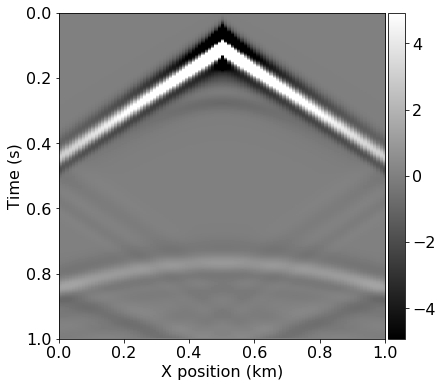

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)